## Crypto Prediction with LSTM: Litecoin (LTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.metrics import R2Score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-14 13:24:00.156992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-14T00:00:00.0000000Z', 'time_period_end': '2023-09-15T00:00:00.0000000Z', 'time_open': '2023-09-14T00:02:53.7140000Z', 'time_close': '2023-09-14T17:22:12.0360000Z', 'price_open': 62.2, 'price_high': 63.34, 'price_low': 62, 'price_close': 62.83, 'volume_traded': 3748.51021538, 'trades_count': 918}, {'time_period_start': '2023-09-13T00:00:00.0000000Z', 'time_period_end': '2023-09-14T00:00:00.0000000Z', 'time_open': '2023-09-13T00:35:45.8010000Z', 'time_close': '2023-09-13T23:51:04.7770000Z', 'price_open': 60.12, 'price_high': 62.84, 'price_low': 59.66, 'price_close': 61.99, 'volume_traded': 7234.45330412, 'trades_count': 1436}, {'time_period_start': '2023-09-12T00:00:00.0000000Z', 'time_period_end': '2023-09-13T00:00:00.0000000Z', 'time_open': '2023-09-12T00:16:01.8860000Z', 'time_close': '2023-09-12T23:57:44.1320000Z', 'price_open': 58.72, 'price_high': 61.46, 'price_low': 58.7, 'price_close': 59.93, 'volume_traded': 4747.15350978, 'trades_count': 1299}, 

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:02:53.7140000Z,2023-09-14T17:22:12.0360000Z,62.20,63.34,62.00,62.83,3748.510215,918
1,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:35:45.8010000Z,2023-09-13T23:51:04.7770000Z,60.12,62.84,59.66,61.99,7234.453304,1436
2,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:16:01.8860000Z,2023-09-12T23:57:44.1320000Z,58.72,61.46,58.70,59.93,4747.153510,1299
3,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:03:19.4380000Z,2023-09-11T23:42:44.3830000Z,61.22,61.62,57.69,58.75,5002.433665,1384
4,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:01:37.8240000Z,2023-09-10T23:54:50.7350000Z,63.05,63.05,60.10,61.13,5918.969065,1017


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


In [5]:
# mydata = nasdaqdatalink.get(["WIKI/TSLA.11"])

In [6]:
# print(mydata)

In [7]:
# data = pd.DataFrame(mydata)

# data = data.rename(columns={"WIKI/TSLA - Adj. Close":"Close"})

# data

In [8]:
# data = pd.read_csv('AMZN.csv')
# data = data[["Date", "Adj Close"]]

# #rename columns
# data = data.rename(columns={"Adj Close":"Close"})

# #convert date to dt, refomat to yyyymmdd
# data['Date'] = pd.to_datetime(data['Date']).dt.date


# #set date as index
# data.set_index('Date', inplace=True)

# data.head()



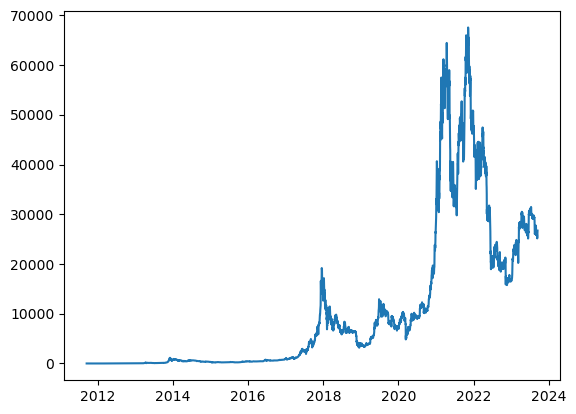

In [10]:
#plot historical amzn price
plt.plot(data)

In [9]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [10]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2250, 7), (2250,), (2250,))

In [11]:
# non_positive_indices = np.where(shifted_df_as_np <= 0)
# print(non_positive_indices)


In [12]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1800, 7), (1800,), (225, 7), (225,), (225, 7), (225,))

In [13]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-14 13:26:15.426885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
57/57 [==============================] - 3s 17ms/step - loss: 4.1022 - mean_absolute_error: 1.4533 - val_loss: 0.0544 - val_mean_absolute_error: 0.2069
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.2083 - mean_absolute_error: 0.3938 - val_loss: 0.0744 - val_mean_absolute_error: 0.2480
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 0.1149 - mean_absolute_error: 0.2874 - val_loss: 0.0535 - val_mean_absolute_error: 0.2185
Epoch 4/100
57/57 [==============================] - 1s 16ms/step - loss: 0.0322 - mean_absolute_error: 0.1412 - val_loss: 0.0159 - val_mean_absolute_error: 0.1148
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0112 - mean_absolute_error: 0.0783 - val_loss: 0.0030 - val_mean_absolute_error: 0.0392
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0078 - mean_absolute_error: 0.0629 - val_loss: 0.0030 - val_mean_absolute_error: 0.0395
Epoch 7/100
57/57 [=

Epoch 51/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0495 - val_loss: 0.0022 - val_mean_absolute_error: 0.0336
Epoch 52/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0474 - val_loss: 0.0043 - val_mean_absolute_error: 0.0531
Epoch 53/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0478 - val_loss: 0.0028 - val_mean_absolute_error: 0.0386
Epoch 54/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0495 - val_loss: 0.0037 - val_mean_absolute_error: 0.0480
Epoch 55/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0572 - val_loss: 0.0022 - val_mean_absolute_error: 0.0340
Epoch 56/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0506 - val_loss: 0.0022 - val_mean_absolute_error: 0.0336
Epoch 57/100
57/

57/57 [==============================] - 1s 3ms/step


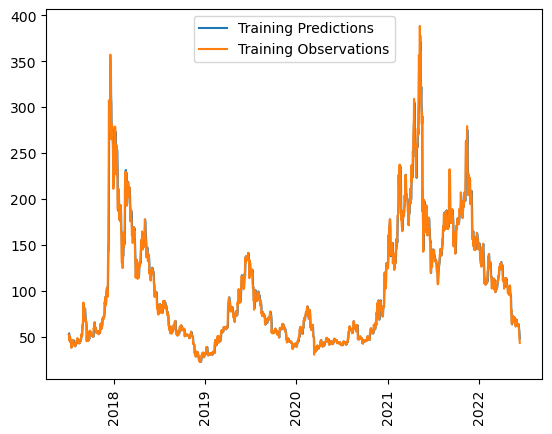

In [14]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [15]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0019123228266835213
Val MAE: 0.03091173805296421


8/8 [==============================] - 0s 3ms/step


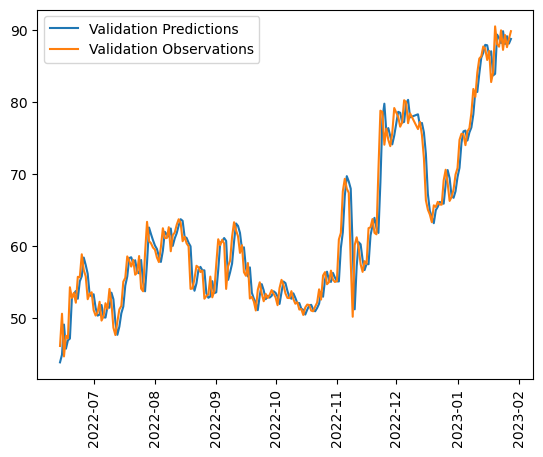

In [16]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [17]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015819491818547249
Test MAE: 0.027037644758820534


8/8 [==============================] - 0s 3ms/step


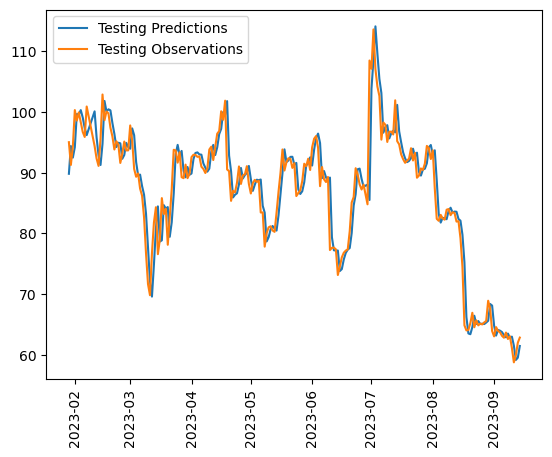

In [18]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [19]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9149081444072636


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [20]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [21]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((877,), (877, 7), (877,), (135,), (135, 7), (135,), (113,), (113, 7), (113,))

In [22]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
28/28 [==============================] - 3s 29ms/step - loss: 13.7403 - mean_absolute_error: 3.6702 - val_loss: 10.2516 - val_mean_absolute_error: 3.2011
Epoch 2/200
28/28 [==============================] - 0s 8ms/step - loss: 9.6588 - mean_absolute_error: 3.0682 - val_loss: 6.7969 - val_mean_absolute_error: 2.6063
Epoch 3/200
28/28 [==============================] - 0s 9ms/step - loss: 6.1970 - mean_absolute_error: 2.4417 - val_loss: 3.7647 - val_mean_absolute_error: 1.9393
Epoch 4/200
28/28 [==============================] - 0s 9ms/step - loss: 3.1733 - mean_absolute_error: 1.7188 - val_loss: 1.3799 - val_mean_absolute_error: 1.1732
Epoch 5/200
28/28 [==============================] - 0s 9ms/step - loss: 1.0733 - mean_absolute_error: 0.9348 - val_loss: 0.1761 - val_mean_absolute_error: 0.4157
Epoch 6/200
28/28 [==============================] - 0s 8ms/step - loss: 0.2143 - mean_absolute_error: 0.3707 - val_loss: 0.0110 - val_mean_absolute_error: 0.0895
Epoch 7/200
28/28 [

Epoch 51/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0094 - mean_absolute_error: 0.0739 - val_loss: 0.0034 - val_mean_absolute_error: 0.0443
Epoch 52/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0090 - mean_absolute_error: 0.0722 - val_loss: 0.0036 - val_mean_absolute_error: 0.0453
Epoch 53/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 54/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_absolute_error: 0.0695 - val_loss: 0.0036 - val_mean_absolute_error: 0.0456
Epoch 55/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_absolute_error: 0.0676 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 56/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_absolute_error: 0.0671 - val_loss: 0.0030 - val_mean_absolute_error: 0.0413
Epoch 57/200
28

Epoch 101/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0600 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394
Epoch 102/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0605 - val_loss: 0.0025 - val_mean_absolute_error: 0.0385
Epoch 103/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0598 - val_loss: 0.0026 - val_mean_absolute_error: 0.0384
Epoch 104/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0597 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394
Epoch 105/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_absolute_error: 0.0596 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399
Epoch 106/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0591 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384
Epoch 107/

28/28 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0557 - val_loss: 0.0028 - val_mean_absolute_error: 0.0423
Epoch 151/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_error: 0.0590 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376
Epoch 152/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0554 - val_loss: 0.0025 - val_mean_absolute_error: 0.0373
Epoch 153/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_absolute_error: 0.0563 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357
Epoch 154/200
28/28 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0551 - val_loss: 0.0028 - val_mean_absolute_error: 0.0398
Epoch 155/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0561 - val_loss: 0.0022 - val_mean_absolute_error: 0.0355
Epoch 156/200
28/28 [===

Epoch 200/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0512 - val_loss: 0.0019 - val_mean_absolute_error: 0.0329


28/28 [==============================] - 1s 3ms/step


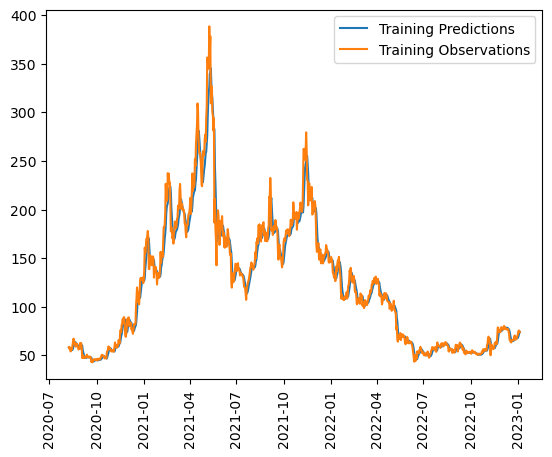

In [23]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [24]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00192986149340868
Val MAE: 0.03287419304251671


5/5 [==============================] - 0s 4ms/step


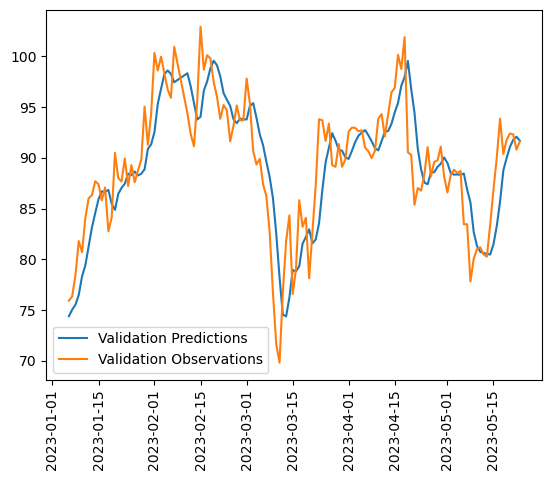

In [25]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [26]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.002805909141898155
Test MAE: 0.035121526569128036


In [27]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 5ms/step
R2 Score:  0.8961400229772826


4/4 [==============================] - 0s 5ms/step


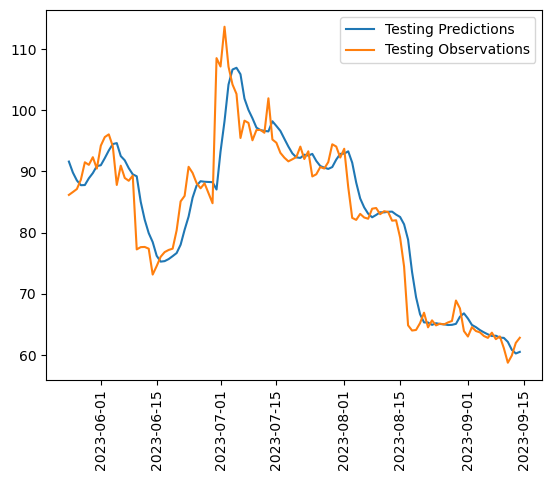

In [28]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [48]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 4s 46ms/step - loss: 18.9601 - mean_absolute_error: 4.3211 - val_loss: 15.8193 - val_mean_absolute_error: 3.9767
Epoch 2/300
28/28 [==============================] - 0s 12ms/step - loss: 15.7897 - mean_absolute_error: 3.9397 - val_loss: 12.6280 - val_mean_absolute_error: 3.5529
Epoch 3/300
28/28 [==============================] - 0s 14ms/step - loss: 11.9815 - mean_absolute_error: 3.4220 - val_loss: 8.4522 - val_mean_absolute_error: 2.9065
Epoch 4/300
28/28 [==============================] - 0s 13ms/step - loss: 7.2852 - mean_absolute_error: 2.6490 - val_loss: 3.9845 - val_mean_absolute_error: 1.9951
Epoch 5/300
28/28 [==============================] - 0s 14ms/step - loss: 2.8598 - mean_absolute_error: 1.6015 - val_loss: 0.7239 - val_mean_absolute_error: 0.8486
Epoch 6/300
28/28 [==============================] - 1s 18ms/step - loss: 0.5150 - mean_absolute_error: 0.5844 - val_loss: 0.0037 - val_mean_absolute_error: 0.0447
Epoch 7/300

Epoch 51/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0583 - val_loss: 0.0028 - val_mean_absolute_error: 0.0396
Epoch 52/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0067 - mean_absolute_error: 0.0590 - val_loss: 0.0024 - val_mean_absolute_error: 0.0371
Epoch 53/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0590 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375
Epoch 54/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0067 - mean_absolute_error: 0.0590 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 55/300
28/28 [==============================] - 1s 19ms/step - loss: 0.0064 - mean_absolute_error: 0.0578 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367
Epoch 56/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0064 - mean_absolute_error: 0.0577 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376
Epoch 57/3

Epoch 101/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0558 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406
Epoch 102/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_absolute_error: 0.0552 - val_loss: 0.0029 - val_mean_absolute_error: 0.0409
Epoch 103/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0544 - val_loss: 0.0022 - val_mean_absolute_error: 0.0357
Epoch 104/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0056 - mean_absolute_error: 0.0539 - val_loss: 0.0023 - val_mean_absolute_error: 0.0362
Epoch 105/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0055 - mean_absolute_error: 0.0533 - val_loss: 0.0027 - val_mean_absolute_error: 0.0389
Epoch 106/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0552 - val_loss: 0.0026 - val_mean_absolute_error: 0.0385
Epoc

28/28 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_absolute_error: 0.0521 - val_loss: 0.0023 - val_mean_absolute_error: 0.0359
Epoch 151/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0049 - mean_absolute_error: 0.0498 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334
Epoch 152/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_absolute_error: 0.0507 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358
Epoch 153/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0516 - val_loss: 0.0020 - val_mean_absolute_error: 0.0330
Epoch 154/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_absolute_error: 0.0512 - val_loss: 0.0025 - val_mean_absolute_error: 0.0377
Epoch 155/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_absolute_error: 0.0511 - val_loss: 0.0021 - val_mean_absolute_error: 0.0353
Epoch 156/300
28/2

28/28 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_absolute_error: 0.0481 - val_loss: 0.0028 - val_mean_absolute_error: 0.0435
Epoch 200/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0052 - mean_absolute_error: 0.0542 - val_loss: 0.0040 - val_mean_absolute_error: 0.0532
Epoch 201/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0484 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341
Epoch 202/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0480 - val_loss: 0.0017 - val_mean_absolute_error: 0.0298
Epoch 203/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_absolute_error: 0.0526 - val_loss: 0.0019 - val_mean_absolute_error: 0.0328
Epoch 204/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0477 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 205/300
28/2

28/28 [==============================] - 1s 35ms/step - loss: 0.0039 - mean_absolute_error: 0.0439 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292
Epoch 249/300
28/28 [==============================] - 1s 40ms/step - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284
Epoch 250/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0041 - mean_absolute_error: 0.0462 - val_loss: 0.0016 - val_mean_absolute_error: 0.0285
Epoch 251/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0468 - val_loss: 0.0020 - val_mean_absolute_error: 0.0354
Epoch 252/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0040 - mean_absolute_error: 0.0452 - val_loss: 0.0017 - val_mean_absolute_error: 0.0307
Epoch 253/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0041 - mean_absolute_error: 0.0456 - val_loss: 0.0017 - val_mean_absolute_error: 0.0313
Epoch 254/300
28/2

28/28 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0020 - val_mean_absolute_error: 0.0353
Epoch 298/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0015 - val_mean_absolute_error: 0.0283
Epoch 299/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_absolute_error: 0.0429 - val_loss: 0.0015 - val_mean_absolute_error: 0.0279
Epoch 300/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_absolute_error: 0.0422 - val_loss: 0.0015 - val_mean_absolute_error: 0.0278


28/28 [==============================] - 1s 3ms/step


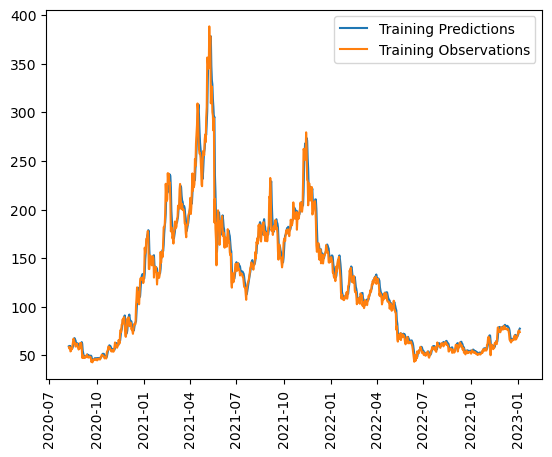

In [30]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [31]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0019989360589534044
Val MAE: 0.035162270069122314


5/5 [==============================] - 0s 3ms/step


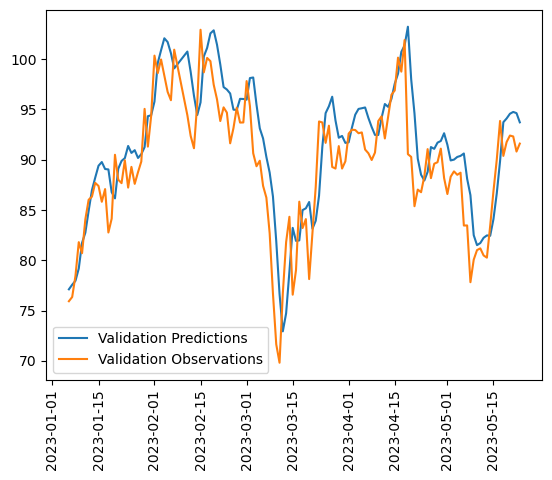

In [32]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [33]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0029734992422163486
Test MAE: 0.04029247537255287


4/4 [==============================] - 0s 5ms/step


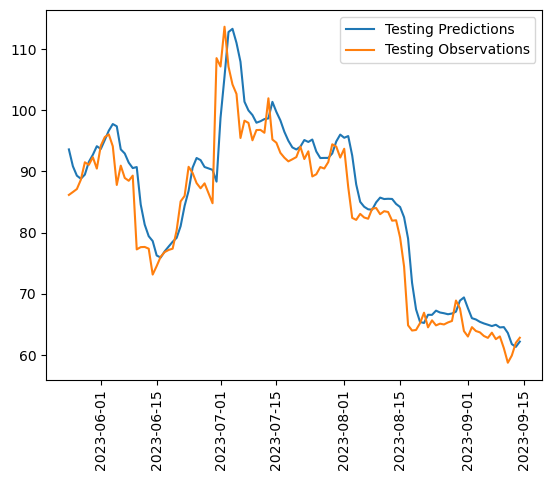

In [45]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [35]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8899365968399389


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [36]:


# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = lookback

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, lookback, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 23ms/step
[4.1304007, 4.143506, 4.158743, 4.1764984, 4.194358, 4.210614, 4.2270103]
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21


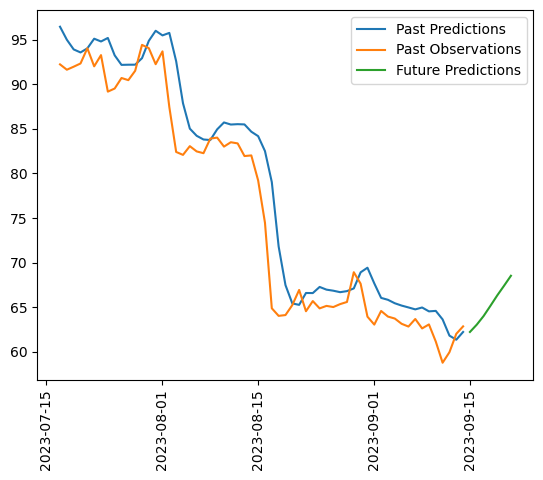

In [37]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [38]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_7_day.h5")

In [39]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2, "observed":np.exp(y_test2), "predicted":np.exp(test_predictions3)})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,predicted,future_prediction
Date,,,
2023-05-24,86.16,93.593491,NaN
2023-05-25,86.63,90.847038,NaN
2023-05-26,87.12,89.306267,NaN
2023-05-27,88.64,88.795395,NaN
2023-05-28,91.49,89.479919,NaN


In [40]:
past_future_df.tail()

,observed,predicted,future_prediction
Date,,,
2023-09-17,NaN,NaN,63.991032
2023-09-18,NaN,NaN,65.137367
2023-09-19,NaN,NaN,66.311134
2023-09-20,NaN,NaN,67.397926
2023-09-21,NaN,NaN,68.512093


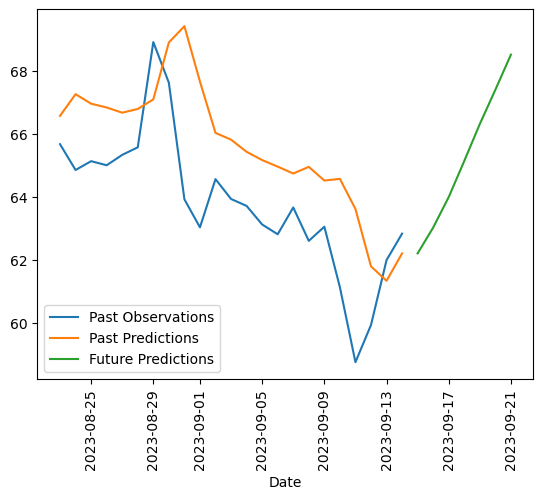

In [41]:
past_future_df[-30:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Past Observations', 'Past Predictions','Future Predictions'])
plt.show()

In [42]:
past_df = pd.read_csv('output/ltc_predict.csv')

past_df = past_df[["predicted"]]

past_df = past_df.rename(columns={"predicted":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

In [49]:
#output prediction data to csv
df.to_csv('output/ltc_predict.csv') 

In [44]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime.csv')

In [ ]:
#output prediction data to csv
df_combined.to_csv('output/ltc_predict_hist.csv') 